In [1]:
from manim import *
from numpy import linalg as npl
import jupyter_capture_output

video_scene = " -v WARNING --progress_bar None --disable_caching fe_Scene"
image_scene = f" -v WARNING --progress_bar None --disable_caching -r {2*427},{2*240}  -s fe_Scene"

Manim Community v0.18.0.post0

Jupyter Capture Output v0.0.11


In [70]:
# function to turn positions into complex numbers
def pos_to_complex(pos_array):
    N = len(pos_array)
    x_array = np.zeros((N,), dtype = np.complex_)
    for n in range(N):
        x_n_real = pos_array[n][0]
        x_n_imag = pos_array[n][1]
        x_array[n] = complex(x_n_real, x_n_imag)
    return x_array


# discrete fourier transform
def dft(x_array):
    N = len(x_array)
    k_array = np.zeros_like(x_array)
    for k in range(N):
        for n in range(N):
            k_array[k] += x_array[n] * np.exp(-1j * 2*np.pi*k/N*n)
    return k_array

In [67]:
class DrawComplexFourier(Mobject):
    def __init__(self, center, k_array, k_max = 0, **kwargs):
        super().__init__(**kwargs)

        self.center = center
        self.N = len(k_array)
        self.k_array = k_array
        if k_max:
            self.k_max = min(len(k_array, k_max))
        else:
            self.k_max = len(k_array)


    # get absolute of a complex number c
    def get_absolute(self, c):
        return np.sqrt(c.real**2 + c.imag**2)


    def get_fourier_circles(self, n):
        fourier_circles_group = VGroup()
        position = self.center                                                      # current postition
        # iterate through the individual frequencies
        for k in range(self.k_max):
            x_k = self.k_array[k]                                                   # get the cuurent complex amplitude
            x_k_abs = self.get_absolute(x_k) / self.N                               # get the current frequency amplitude

            x_n = x_k / self.N * np.exp(1j * 2*np.pi *k/self.N*n)                   # get the current complex value
            x_n_real = x_n.real                                                     # get the real part of x_n
            x_n_imag = x_n.imag                                                     # get the imaginary part of x_n

            circle = Circle(radius = x_k_abs, color = WHITE, stroke_width = 0.25).move_to(position)
            arrow = Line(start = position, end = position + np.array([x_n_real, x_n_imag, 0]), color = WHITE, stroke_width = 2).add_tip(tip_length = 0.15, tip_width = 0.15)
            fourier_circles_group.add(circle, arrow)

            # update position
            position[0] += x_n_real
            position[1] += x_n_imag
                                                              
        return fourier_circles_group

Output saved by creating file at ../animations/fourier_elephant/fourier_elephant.mp4.


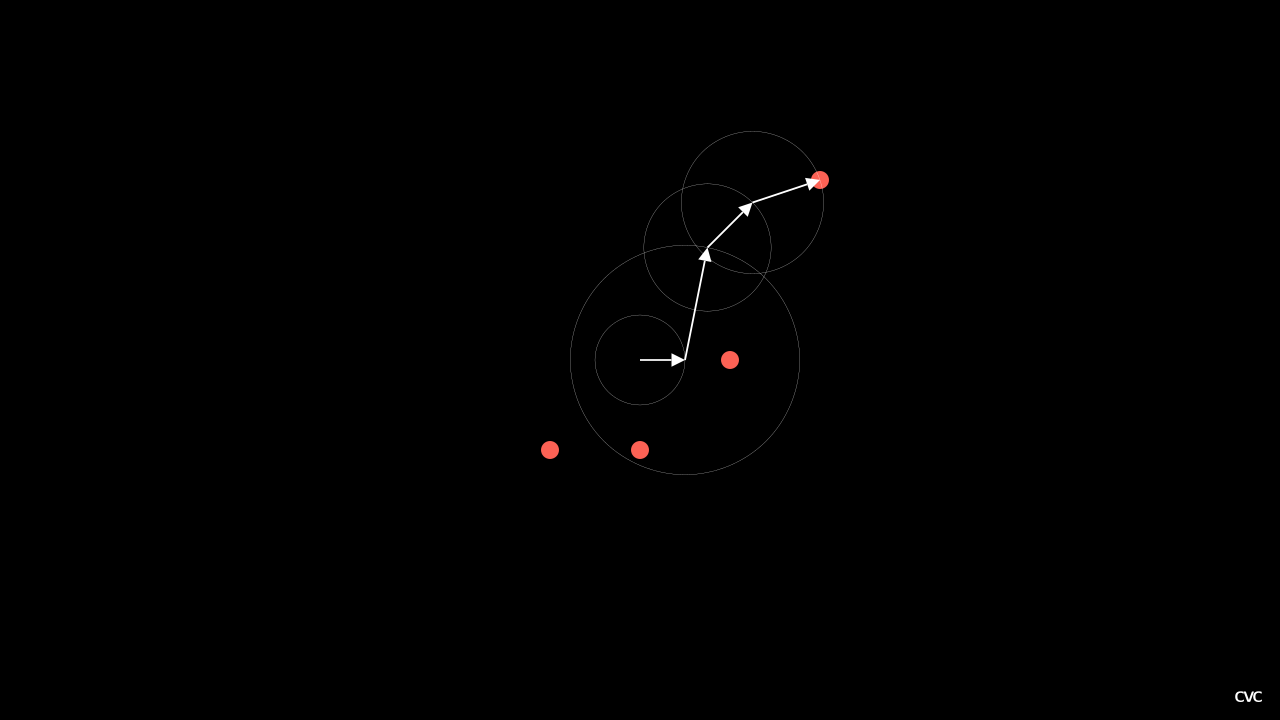

In [68]:
%%capture_video --path "../animations/fourier_elephant/fourier_elephant.mp4"
%%manim -qm --fps 60 $video_scene


class fe_Scene(ThreeDScene):
    def construct(self):
        CVC = Text('CVC', font_size = 12, weight = BOLD, color = WHITE, font = 'Latin Modern Sans').align_on_border(RIGHT + DOWN, buff = 0.2)
        self.add(CVC)

        center = np.array([0.0, 0, 0])


        # positions list
        pos_list = [
            (-1, -1, 0),
            (0, -1, 0),
            (1, 0, 0),
            (2, 2, 0)
        ]


        # draw pos list
        def draw_pos_list(pos_list):
            len_pos_list = len(pos_list)
            for i in range(len_pos_list):
                self.add(Dot(point = pos_list[i], color = RED, radius = 0.1))

        
        draw_pos_list(pos_list)

        # transformations
        x_array = pos_to_complex(pos_list)          # transform positions to complex numbers
        k_array = dft(x_array)                      # dft the complex numbers to the fourier space
        
        fourier = DrawComplexFourier(center, k_array)
        self.add(fourier)

        fourier_circles = fourier.get_fourier_circles(3)
        self.add(fourier_circles)

        